#АНАЛИЗ РЫНКА ВАКАНСИЙ АНАЛИТИКОВ ДАННЫХ (на LinkedIn)

In [117]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Необходимо провести анализ и визуализировать информацию о существующих вакансиях для аналитиков данных, опубликованных на ресурсе LinkedIn.

***Цель проекта:*** визуализация информации о рынке вакансий аналитиков данных в Европе.

***Источник данных:*** csv-файл, требующий распарсинга.

***Декомпозиция проекта:***
1. Импорт данных, рассмотрение общей информации;
2. Вывод необходимой информации из файла, создание следующих признаков:
- Наименование вакансии;
- Город;
- Страна;
- Тип занятости (remote, hybride, on-site);
- Компания;
- Размер компании (количество работников);
- Сфера деятельности компании;
- Требуемые хард скилы;
- Дата публикации вакансии;
- Количество кандидатов на вакансию.
3. Предварительная обработка данных (проверка типов данных (изменение в случае необходимости), проверка на пропуски (заполнение в случае необходимости) и дубликаты (явные и неявные), выявление выбросов), удаление ненужных признаков.
4. Визуализация данных путем построения интерактивного дашборда, включающего в себя следующие компоненты:
- фильтры по стране и типу занятости;
- количество вакансий (абсолютные значения);
- количество вакансий по странам (относительные значения, stack bar chart);
- тип занятости (pie chart);
- список нанимающих компаний и указанием количества вакансий, отсортированный в порядке убывания (heat map);
- Топ-10 сфер деятельности компаний, которые нанимают аналитиков (bar chart);
- размер компаний и количество вакансий (pie chart);
- хард скилы.

## Импорт данных и общая информация

Импортируем необходимые библиотеки:

In [118]:
import pandas as pd
import re
import numpy as np
from bs4 import BeautifulSoup
from IPython.display import display, HTML
import datetime as dt
import warnings

In [119]:
warnings.filterwarnings('ignore')

Сохраним данные в датасет:

In [120]:
puth_1 = '/content/drive/MyDrive/Портфолио/LinkedIn/masterskaya_parsing_LinkedIn_2023_05_23.csv'
puth_2 = 'https://yadi.sk/d/Rlo2KdJRve6fkw'

In [121]:
try:
  data = pd.read_csv(puth_1)
except:
  data = pd.read_csv(puth_2)

Выведем инфомацию о датасете и первые 5 строк, используя функцию:

In [122]:
def head_info(data):
    display(data.head())
    display(data.info())

In [123]:
head_info(data)

,Unnamed: 0,html
0,0,"\n <div>\n <div class=""\n jobs-deta..."
1,1,"\n <div>\n <div class=""\n jobs-deta..."
2,2,"\n <div>\n <div class=""\n jobs-deta..."
3,3,"\n <div>\n <div class=""\n jobs-deta..."
4,4,"\n <div>\n <div class=""\n jobs-deta..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998 entries, 0 to 997
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  998 non-null    int64 
 1   html        998 non-null    object
dtypes: int64(1), object(1)
memory usage: 15.7+ KB


None

Удалим столбец `Unnamed: 0`:

In [124]:
data = data.drop(columns = ['Unnamed: 0'],axis = 1)

Проверим датасет на явные дубликаты и пропуски, используя функцию:

In [125]:
def check_data(data):
    print('Всего найдено пропусков:')
    display(pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm'))
    dubl = data.duplicated().sum()
    print()
    if dubl == 0:
        print('Дубликатов не найдено')
    else:
        print('Всего найдено дубликатов:', dubl)
        data = data.drop_duplicates().reset_index(drop=True)
        print()
        print('Дубликаты удалены')
        print()
        print('Обновленная информация о датасете:')
        print()
        data.info()
    return data

In [126]:
data = check_data(data)

Всего найдено пропусков:


,0
html,0.000000



Всего найдено дубликатов: 98

Дубликаты удалены

Обновленная информация о датасете:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   html    900 non-null    object
dtypes: object(1)
memory usage: 7.2+ KB


*Таким образом, удалили 98 дубликатов.*

Рассмотрим, как выглядит объект из столбца `html` датасета:

In [127]:
display(HTML(data['html'][0]))

***На данном этапе датасет состоит из 900 строк с 'html' под каждую из вакансий.***

## Вывод необходимой информации и создание признаков

### Наименования вакансий

Используя библиотеку BeautifulSoup, добавим в датасет столбец `name_vacancy` с названием вакансий (предварительно исследовав код, узнали, что наименование имеет тег `h2`, class = 't-24 t-bold jobs-unified-top-card__job-title').
Для дальнейшего удобства создадим функцию `get_inf`:

In [128]:
def get_inf(html,      #столбец датасета с данными парсинга
            teg,       #тег необходимого признака
            class_name #класс необходимого признака
            ):
  try:
    new_col = html.apply(lambda x: BeautifulSoup(x, 'lxml').find(teg, class_ = class_name).text.strip())
  except:
    new_col = html.apply(lambda x: BeautifulSoup(x, 'lxml').find(teg, class_ = class_name))
  return new_col

Используем функцию:

In [129]:
data['name_vacancy'] = get_inf(data['html'], 'h2', 't-24 t-bold jobs-unified-top-card__job-title')

Выведем первые строки датасета:

In [130]:
data.head()

,html,name_vacancy
0,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst
1,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst - Logistics
2,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst - Logistics
3,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst (Space & Planning)
4,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst


Рассмотрим варианты указанных вакансий:

In [131]:
data['name_vacancy'].unique()

array(['Data Analyst', 'Data Analyst - Logistics',
       'Data Analyst (Space & Planning)', 'Data Analyst - Hybrid Working',
       'Commercial Data Analyst', 'Asset Data Analyst',
       'Data Analyst - Hybrid', 'Data Analyst (FT)', 'Data Analyst H/F',
       'Data Analyst II', 'Data Analyst (9 Months FTC)',
       'Business Intelligence Analyst', 'Data Analyst (F/H)',
       'BI Analyst', 'Data Analyst Associate', 'Product Data Analyst',
       'Graduate Data Analyst', 'Digital Data Analyst',
       'Business Intelligence Analyst Junior', 'Data analyst H/F',
       'Data Analyst (m/f/d)', 'Analytics Consultant', 'Data Analyst F/H',
       'Consultor BI', 'Statistical Data Analyst',
       'Digital Data Analyst (H/F)',
       'Data Analyst - €60,- per hour - Amsterdam based',
       'Data & Analytics Senior Analyst',
       'JUNIOR DATA ANALYST – Aerospace', 'Data Analyst - Operations',
       'Data Analyst (H/F)', 'BUSINESS INTELLIGENCE ANALYST',
       'Business Intelligence Analys

*Среди выведенных вакансий присутствуют те, который не относятся к целевым. Сохраним датасет, только с вакансиями, включающими Data Analyst, Data Scientist и BI Analyst.*

In [132]:
df = data.loc[data['name_vacancy'].str.contains('[Dd]ata [Aa]nal'
    )|data['name_vacancy'].str.contains('[Dd]ata [Ss]cie'
    )|data['name_vacancy'].str.contains('[Bb][Ii] [Aa]nalyst')
    ].reset_index(drop = True)

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473 entries, 0 to 472
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   html          473 non-null    object
 1   name_vacancy  473 non-null    object
dtypes: object(2)
memory usage: 7.5+ KB


*Сократили датасет более чем в 2 раза.*

Выведем оставшиеся наименования вакансий:

In [134]:
df['name_vacancy'].unique()

array(['Data Analyst', 'Data Analyst - Logistics',
       'Data Analyst (Space & Planning)', 'Data Analyst - Hybrid Working',
       'Commercial Data Analyst', 'Asset Data Analyst',
       'Data Analyst - Hybrid', 'Data Analyst (FT)', 'Data Analyst H/F',
       'Data Analyst II', 'Data Analyst (9 Months FTC)',
       'Data Analyst (F/H)', 'BI Analyst', 'Data Analyst Associate',
       'Product Data Analyst', 'Graduate Data Analyst',
       'Digital Data Analyst', 'Data analyst H/F', 'Data Analyst (m/f/d)',
       'Data Analyst F/H', 'Statistical Data Analyst',
       'Digital Data Analyst (H/F)',
       'Data Analyst - €60,- per hour - Amsterdam based',
       'Data Analyst - Operations', 'Data Analyst (H/F)',
       'Junior Data Analyst', 'Web Data Analyst F/H',
       'Junior Data Analyst Power BI - CONTRATO 6 MESES',
       'Data Analyst - Milano', 'Data Analyst (Engineer)',
       'Data Analyst H/F _ CDD', 'Data Analyst - Analyste de données',
       'BI Analyst, Power BI Champion,

***Таким образом, 473 вакансии остались для дальнейшего анализа. В дальнейшей обработке данных необходимо рассмотреть возможность унификации названий вакансий.***

### Город и страна

Аналогичным способом добавим в датасет столбцы `city` и `country` с названием города и страны вакансии. Данная информация в коде имеет тег `span` и `class`='jobs-unified-top-card__bullet':

Для начала сохраним в переменную `location` данные, обработанные BeautifulSoup:

In [135]:
location = get_inf(df['html'], 'span', 'jobs-unified-top-card__bullet')
location

0                        Basel, Basel, Switzerland
1                Coventry, England, United Kingdom
2                Coventry, England, United Kingdom
3            South Molton, England, United Kingdom
4                      Lugano, Ticino, Switzerland
                          ...                     
468    Boulogne-Billancourt, Île-de-France, France
469           Marcallo con Casone, Lombardy, Italy
470                        Naples, Campania, Italy
471                   Paris, Île-de-France, France
472                      Vermezzo, Lombardy, Italy
Name: html, Length: 473, dtype: object

In [136]:
#удалим лишние пробелы:
location = location.apply(lambda x: re.sub(', ', ',', x))
location

0                        Basel,Basel,Switzerland
1                Coventry,England,United Kingdom
2                Coventry,England,United Kingdom
3            South Molton,England,United Kingdom
4                      Lugano,Ticino,Switzerland
                         ...                    
468    Boulogne-Billancourt,Île-de-France,France
469           Marcallo con Casone,Lombardy,Italy
470                        Naples,Campania,Italy
471                   Paris,Île-de-France,France
472                      Vermezzo,Lombardy,Italy
Name: html, Length: 473, dtype: object

In [137]:
#разделим по запятым:
location = location.apply(lambda x: x.split(','))
location

0                        [Basel, Basel, Switzerland]
1                [Coventry, England, United Kingdom]
2                [Coventry, England, United Kingdom]
3            [South Molton, England, United Kingdom]
4                      [Lugano, Ticino, Switzerland]
                           ...                      
468    [Boulogne-Billancourt, Île-de-France, France]
469           [Marcallo con Casone, Lombardy, Italy]
470                        [Naples, Campania, Italy]
471                   [Paris, Île-de-France, France]
472                      [Vermezzo, Lombardy, Italy]
Name: html, Length: 473, dtype: object

*Кааждая информация о расположении имеет в основном 3 объекта: город, регион и страну.*
Сохраним в переменные `city` данные, соответствующие индексу 0 в каждом из списков, а в столбец `country` - индексу -1:

In [138]:
#создадим списки с названиями городов и стран
city = []
country = []
for element in location:
  city.append(element[0])
  country.append(element[-1])
print(city)
print(country)

['Basel', 'Coventry', 'Coventry', 'South Molton', 'Lugano', 'Southampton', 'Leeds', 'Nuneaton', 'Paris', 'Cambridge', 'West Midlands', 'Schiphol', 'Chester', 'Cambridge', 'Craven Arms', 'Dublin', 'Belfast', 'Sunderland', 'Montévrain', 'Bristol', 'South Molton', 'Bristol', 'Solihull', 'Dublin', 'Blackpool', 'Dijon', 'Alsónémedi', 'Manchester', 'Elliniko-Argyroupoli', 'Umeå', 'North Holland', 'Vilnius', 'Durham', 'Oudenaarde', 'Stockholm County', 'Luxembourg', 'Roubaix', 'Munich', 'Milan', 'Zaventem', 'Milan', 'Brussels Metropolitan Area', 'Portugal', 'West Malling', 'Greater Paris Metropolitan Region', 'France', 'Brussels Metropolitan Area', 'Lille', 'Milan', 'Egham', 'Milan', 'Karlstad', 'Madrid', 'Roubaix', 'Oxford', 'Hungary', 'Brussels', 'Paris', 'Taibon', 'Paris', 'Epsom', 'Amsterdam', 'Spinea', 'Greater Paris Metropolitan Region', 'Amsterdam', 'Boulogne-Billancourt', 'Nantes', 'Derby', 'Milan', 'Lund', 'Amsterdam', 'Greater Paris Metropolitan Region', 'Garwolin', 'Oudenaarde', 'Pa

Проверим, все ли указанные страны отвечают требованиям ТЗ и находятся на территории Европы:

In [139]:
#полный список стран Европы
countries_of_europe = ["Austria","Albania","Andorra","Belarus","Belgium","Bulgaria","Bosnia and Herzegovina","Vatican","United Kingdom","Hungary","Germany","Greece","Denmark","Ireland","Iceland","Spain","Italy",
"Kosovo","Latvia","Lithuania","Liechtenstein","Luxembourg","Macedonia","Malta","Moldova","Monaco","Netherlands","Norway","Poland","Portugal","Russia","Romania","San-Marino","Serbia","Slovakia","Slovenia","Ukraine",
"Finland","France","Croatia","Montenegro","Czech Republic","Switzerland","Sweden","Estonia"]

In [140]:
#цикл для проверки
not_europe = []
a = []
for value in country:
  if value not in countries_of_europe:
    a.append(value)
    for i in a:
      if i not in not_europe:
        not_europe.append(i)
print(not_europe)
print()
print('Всего найдено стран:', len(not_europe))

['Brussels Metropolitan Area', 'Greater Paris Metropolitan Region', 'Czechia', 'Warsaw Metropolitan Area', 'Wroclaw Metropolitan Area', 'Greater Barcelona Metropolitan Area', 'Iasi Metropolitan Area', 'Cologne Bonn Region', 'Greater Munster Area', 'Greater Banska Bystrica Area', 'Greater Nuremberg Metropolitan Area', 'Berlin Metropolitan Area', 'Rotterdam and The Hague', 'Greater Pau Area', 'Athens Metropolitan Area', 'Stuttgart Region', 'Greater Milan Metropolitan Area', 'Eindhoven Area', 'Krakow Metropolitan Area']

Всего найдено стран: 19


*Как видно в список стран попали регионы, муниципальные округа (Metropolitan Areа), заменим их наименования на названия стран:*

In [141]:
#словарь для замены:
for_change = {
'Brussels Metropolitan Area' : "Belgium",
'Greater Paris Metropolitan Region' : "France",
'Czechia' : "Czech Republic",
'Warsaw Metropolitan Area' : "Poland",
'Wroclaw Metropolitan Area' : "Poland",
'Greater Barcelona Metropolitan Area' : "Spain",
'Iasi Metropolitan Area' : "Romania",
'Cologne Bonn Region' : "Germany",
'Greater Munster Area' : "Ireland",
'Greater Banska Bystrica Area' : "Slovakia",
'Greater Nuremberg Metropolitan Area' : "Germany",
'Berlin Metropolitan Area' : "Germany",
'Rotterdam and The Hague' : "Netherlands",
'Greater Pau Area' : "France",
'Athens Metropolitan Area' : "Greece",
'Stuttgart Region' : "Germany",
'Greater Milan Metropolitan Area' : "Italy",
'Eindhoven Area' : "Netherlands",
'Krakow Metropolitan Area' : "Poland"
}

In [142]:
country = [for_change.get(i, i)for i in country]

Проверим наименования город на написание:

In [143]:
city_check = []
for value in city:
  if value not in city_check:
    city_check.append(value)
city_check.sort()
city_check

['Ahlen',
 'Aix-en-Provence',
 'Alsónémedi',
 'Amsterdam',
 'Arconate',
 'Arluno',
 'Arnhem',
 'Athens',
 'Athens Metropolitan Area',
 'Baierbrunn',
 'Barcelona',
 'Basel',
 'Basingstoke',
 'Bath',
 'Belfast',
 'Bellinzago Lombardo',
 'Bergen op Zoom',
 'Bergisch Gladbach',
 'Berlin',
 'Berlin Metropolitan Area',
 'Bertrange',
 'Binasco',
 'Blackpool',
 'Bodelshausen',
 'Bollate',
 'Bologna',
 'Bordeaux',
 'Boulogne-Billancourt',
 'Bracknell',
 'Bremen',
 'Bristol',
 'Brussels',
 'Brussels Metropolitan Area',
 'Brussels Region',
 'Bucharest',
 'Buckinghamshire',
 'Budapest',
 'Bulgaria',
 'Calvignasco',
 'Cambridge',
 'Canegrate',
 'Carpiano',
 "Cassano d'Adda",
 "Cassina de' Pecchi",
 'Cerdanyola del Vallès',
 'Cernusco sul Naviglio',
 'Cesate',
 'Chappes',
 'Chaucer',
 'Chester',
 'Coimbra',
 'Cologne',
 'Cologne Bonn Region',
 'Colturano',
 'Cork',
 'Cornaredo',
 'Corsico',
 'County Dublin',
 'Courbevoie',
 'Coventry',
 'Cracow',
 'Craven Arms',
 'Croix',
 'Crolles',
 'Cusago',
 'Cu

*В наименованиях городов встречаются регионы и варианты написания не на английском языке.*

Используя словарь, заменим названия образом, аналогичным для замены стран:

In [144]:
#словарь для замены:
for_change_city = {
"Alsónémedi":"Alsonemedi",
"AthensMetropolitanArea":"Athens",
"BerlinMetropolitanArea":"Berlin",
"BrusselsMetropolitanArea":"Brussels",
"BrusselsRegion":"Brussels",
"CerdanyoladelVallès":"CerdanyoladelValles",
"CologneBonnRegion":"Cologne",
"Düsseldorf":"Dгsseldorf",
"EindhovenArea":"Eindhoven",
"FlemishRegion":"Antwerp",
"Gdańsk":"Gdansk",
"Gießen":"Giessen",
"GreaterBanskaBystricaArea":"BanskaBystrica",
"GreaterBarcelonaMetropolitanArea":"Barcelona",
"GreaterMilanMetropolitanArea":"Milan",
"GreaterMunsterArea":"Munster",
"GreaterNurembergMetropolitanArea":"Nuremberg",
"GreaterParisMetropolitanRegion":"Paris",
"GreaterPauArea":"Pau",
"Grünheide":"Grunheide",
"Höchberg":"Hochberg",
"IasiMetropolitanArea":"Iasi",
"Île-de-France":"Paris",
"Iráklion":"Iraklion",
"JonkopingCounty":"Jonkoping",
"KrakowMetropolitanArea":"Krakow",
"LaDéfense":"Paris",
"Liège":"Liege",
"Łódź":"Lodz",
"Luleå":"Lulea",
"Mönchengladbach":"Monchengladbach",
"MülheimanderRuhr":"MulheimanderRuhr",
"Münster":"Munster",
"Olèrdola":"Olerdola",
"Orosháza":"Oroshaza",
"SchwäbischGmünd":"SchwabischGmund",
"StuttgartRegion":"Stuttgart",
"Umeå":"Umea",
"WarsawMetropolitanArea":"Warsaw",
"WroclawMetropolitanArea":"Wroclaw"
}

In [145]:
city = [for_change_city.get(i, i)for i in city]

Учитывая, что несмотря на произведенные замены, все страны все равно относятся к странам Европы, добавим столбцы в датасет и количество вакансий оставим без изменений:

In [146]:
df['city'] = city
df['country'] = country
df

,html,name_vacancy,city,country
0,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst,Basel,Switzerland
1,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst - Logistics,Coventry,United Kingdom
2,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst - Logistics,Coventry,United Kingdom
3,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst (Space & Planning),South Molton,United Kingdom
4,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst,Lugano,Switzerland
...,...,...,...,...
468,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst / Risques de Crédit - Boursorama-...,Boulogne-Billancourt,France
469,"\n <div>\n <div class=""\n jobs-deta...",Stage | Data Analyst,Marcallo con Casone,Italy
470,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst Job In Overseas,Naples,Italy
471,"\n <div>\n <div class=""\n jobs-deta...",Emerton Data: Data Scientist & Strategy Consul...,Paris,France


В городах также присутствовали названиям стран: Finland, Italy, Lithuania, Poland. Посмотрим, что это за вакансии:

In [147]:
mistake_city = ['Finland', 'Italy', 'Lithuania', 'Poland']

In [148]:
df.loc[df['city'].isin(mistake_city)]

,html,name_vacancy,city,country
292,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst (Product Data Analyst),Poland,Poland
316,"\n <div>\n <div class=""\n jobs-deta...",Data Scientist,Italy,Italy
323,"\n <div>\n <div class=""\n jobs-deta...",Sales Data Analyst,Poland,Poland
328,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst - Finance,Poland,Poland
345,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst (Engineer),Poland,Poland
353,"\n <div>\n <div class=""\n jobs-deta...",Data Scientist,Finland,Finland
415,"\n <div>\n <div class=""\n jobs-deta...",Data Scientist (Credit),Poland,Poland
421,"\n <div>\n <div class=""\n jobs-deta...",Data Scientist (Credit),Lithuania,Lithuania
426,"\n <div>\n <div class=""\n jobs-deta...",Data Scientist,Italy,Italy


Посмотрим описания этих вакансий, возможно, там есть данные о городах:

In [149]:
display(HTML(df['html'][292]))

In [150]:
display(HTML(df['html'][316]))

*В данной вакансии указывают возможность работы в 2 офисах на выбор:Сremona or Milano.*

In [151]:
display(HTML(df['html'][323]))

In [152]:
display(HTML(df['html'][328]))

In [153]:
display(HTML(df['html'][345]))

In [154]:
display(HTML(df['html'][353]))

In [155]:
display(HTML(df['html'][415]))

In [156]:
display(HTML(df['html'][421]))

In [157]:
display(HTML(df['html'][426]))

Рассмотрев детально указанные вакансии, можем добавить только в одну строку значение Milano, поскольку расстояние между городами небольшое, но Милан крупный центр.

In [158]:
df['city'][316] = 'Milan'

Для проверки выведем информацию о датасете:

In [159]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473 entries, 0 to 472
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   html          473 non-null    object
 1   name_vacancy  473 non-null    object
 2   city          473 non-null    object
 3   country       473 non-null    object
dtypes: object(4)
memory usage: 14.9+ KB


***Пропусков в столбцах не обнаружено, в датасет добавлены признаки по городу и стране вакансии. Проведена проверка на соответствии техническому заданию (вакансии стран Европы).***

### Тип занятости



Аналогичным способом добавим в датасет столбец `type` с названием типа занятости вакансии. Данная информация в коде имеет тег `span` и `class`="jobs-unified-top-card__workplace-type":

In [160]:
types = get_inf(df['html'], 'span', 'jobs-unified-top-card__workplace-type')

Преобразуем выражения в строковые:

In [161]:
types = types.apply(lambda x: x.__str__())
types.unique()

array(['<span class="jobs-unified-top-card__workplace-type">On-site</span>',
       '<span class="jobs-unified-top-card__workplace-type">Hybrid</span>',
       'None',
       '<span class="jobs-unified-top-card__workplace-type">Remote</span>'],
      dtype=object)

Используем функцию для преобразования данных: в случае пропусков, укажем "No data", в ином случае выведем "On-site", "Hybrid" или "Remote":

In [162]:
types = types.apply(lambda x: 'No data' if x == 'None' else re.search('(?<=>)\w+(?=<)|(?<=>)..-....(?=<)', x).group(0))

Выведем уникальные значения списка:

In [163]:
types.unique()

array(['On-site', 'Hybrid', 'No data', 'Remote'], dtype=object)

Добавим итоговый столбец в датасет:

In [164]:
df['type'] = types
df.head()

,html,name_vacancy,city,country,type
0,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst,Basel,Switzerland,On-site
1,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst - Logistics,Coventry,United Kingdom,On-site
2,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst - Logistics,Coventry,United Kingdom,On-site
3,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst (Space & Planning),South Molton,United Kingdom,On-site
4,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst,Lugano,Switzerland,On-site


Узнаем, сколько строк не содержит информации о типе занятости:

In [165]:
print('Количество вакансий без указанного типа занятости:', df['type'].loc[df['type'] == 'No data'].count())

Количество вакансий без указанного типа занятости: 42


Проверим информацию о датасете:

In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473 entries, 0 to 472
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   html          473 non-null    object
 1   name_vacancy  473 non-null    object
 2   city          473 non-null    object
 3   country       473 non-null    object
 4   type          473 non-null    object
dtypes: object(5)
memory usage: 18.6+ KB


***Необходимый признак добавлен типа занятости добавлен в датасет, однако, при дальнейшей работе необходимо учитывать, что почти 9% не имеют необходимой информации.***

### Наименования компаний

Аналогичным способом добавим в датасет столбец `company_name` с названием компании. Данная информация в коде имеет тег `span` и `class`="jobs-unified-top-card__company-name" (используем функцию `get_inf`):

In [167]:
df['company_name'] = get_inf(df['html'], 'span', "jobs-unified-top-card__company-name")

In [168]:
df.head()

,html,name_vacancy,city,country,type,company_name
0,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst,Basel,Switzerland,On-site,PharmiWeb.Jobs: Global Life Science Jobs
1,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst - Logistics,Coventry,United Kingdom,On-site,Resolute Recruitment
2,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst - Logistics,Coventry,United Kingdom,On-site,Resolute Recruitment
3,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst (Space & Planning),South Molton,United Kingdom,On-site,Mole Valley Farmers
4,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst,Lugano,Switzerland,On-site,FORFIRM


Проверим, нет ли в строках пропущенных значений:

In [169]:
df['company_name'].value_counts().sum()

473

Проверим названия компаний на неявные дубликаты:

In [170]:
companies = df['company_name']
companies = companies.tolist()
companies = list(set(companies))
companies.sort()
companies

['',
 '1&1 Mail & Media Applications SE - GMX | WEB.DE | mail.com',
 '24S',
 '3E',
 'A. Lange & Söhne',
 'ACS Recruitment Solutions',
 'AGS S.\u200bp.\u200bA.\u200b',
 'AUTODOC',
 'AXA Investment Managers',
 'Abbott',
 'Accor',
 'Action',
 'Adecco',
 'Agoda',
 'Airbus',
 'Albert Cliff',
 'Alfa Group',
 'Alpha Bank',
 'Alteca',
 'Amadeus FiRe',
 'Antella Travel Recruitment',
 'Aon',
 'Aplazame',
 'Applus+ Laboratories',
 'Artefact',
 'Artemys Agil-IT (groupe Artemys)',
 'AstraZeneca',
 'Ausy Belgium',
 'Avon',
 'Avvale',
 'Awin Global',
 'Axon Moore',
 'BCEE',
 'BMW Group',
 'BNP Paribas',
 'Babcock',
 'Babcock International Group',
 'BancoBPM',
 'Bandai Namco Europe',
 'Banque Populaire Rives de Paris',
 'Behaviour – UK North',
 'Belfius',
 'Belgie Vacature Groep',
 'Benchmark International',
 'Berkley Group',
 'BillEase',
 'Black Fox Solutions',
 'Bloom & Wild',
 'Blue Arrow',
 'Boursorama',
 'Bouygues Telecom',
 'Bridgestone EMIA',
 'BrightStone Group',
 'Brunel',
 'Bunge',
 "Burton'

 *Среди названий компаний встречаются названия международных компаний разных стран ('PwC France', 'PwC Polska') либо названия дочерних компаний ('Alfa Group', 'Alpha Bank'). В целом производить замены в таких случаях нет особого смысла.*

***Количество названий компаний совпадает с количеством строк в датасете, пропусков нет.***

### Количество откликов

Распарсим данные по количеству откликов, используя функцию `get_inf`:

In [171]:
applicants = get_inf(df['html'], 'span', "jobs-unified-top-card__applicant-count")
applicants

0      [\n                      47 applicants\n      ...
1                                                   None
2                                                   None
3                                                   None
4                                                   None
                             ...                        
468    [\n                      53 applicants\n      ...
469    [\n                      1 applicant\n        ...
470    [\n                      4 applicants\n       ...
471    [\n                      188 applicants\n     ...
472                                                 None
Name: html, Length: 473, dtype: object

In [172]:
#поменяем тип данных на строковые
applicants = applicants.apply(lambda x: x.__str__())


Пропуски в данных (значения "None"), можно рассматривать как отсутствие откликов на момент сбора информации. Заменим пропуски на значение 0, из других строк оставим только числовые выражения:

In [173]:
applicants = applicants.apply(lambda x: 0 if x == 'None' else re.search('\d{1,}', x).group(0))
applicants

0       47
1        0
2        0
3        0
4        0
      ... 
468     53
469      1
470      4
471    188
472      0
Name: html, Length: 473, dtype: object

Добавим итоговый столбец в датасет, и сразу поменяем тип данных на целочисленные значения:

In [174]:
df['applicants'] = applicants
df['applicants'] = df['applicants'].astype(int)
df.head()

,html,name_vacancy,city,country,type,company_name,applicants
0,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst,Basel,Switzerland,On-site,PharmiWeb.Jobs: Global Life Science Jobs,47
1,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst - Logistics,Coventry,United Kingdom,On-site,Resolute Recruitment,0
2,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst - Logistics,Coventry,United Kingdom,On-site,Resolute Recruitment,0
3,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst (Space & Planning),South Molton,United Kingdom,On-site,Mole Valley Farmers,0
4,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst,Lugano,Switzerland,On-site,FORFIRM,0


***Необходимый признак добавлен, пустые строки заменены на 0.***

### Сферы деятельности и размер компании

Сфера деятельности и количество сотрудников (размер компании) указаны в одном блоке (тег='div', class= "t-14 mt5").
Распарсим данные:

In [175]:
industry_employees = get_inf(df['html'], 'div', "t-14 mt5")
industry_employees

0      [\n      Staffing & Recruiting\n        , [\n ...
1                                                   None
2                                                   None
3                                                   None
4                                                   None
                             ...                        
468    [\n      Financial Services\n        , [\n    ...
469    [\n      Retail\n        , [\n          51-200...
470                                                 None
471    [\n      Management Consulting\n        , [\n ...
472    [\n      Retail\n        , [\n          51-200...
Name: html, Length: 473, dtype: object

Удалим ненужные пробелы и разделим строковые значения:

In [176]:
industry_employees = industry_employees.apply(lambda x: x.__str__())
industry_employees = industry_employees.apply(lambda x: re.sub(' ','', x))
industry_employees = industry_employees.apply(lambda x: x.split('\n'))
industry_employees = industry_employees.tolist()
industry_employees[0]

['<divclass="t-14mt5">',
 'Staffing&amp;Recruiting',
 '<spanclass="jobs-company__inline-information">',
 '11-50employees',
 '</span>',
 '<spanclass="jobs-company__inline-information">',
 '18onLinkedIn',
 '</span>',
 '</div>']

Создадим списки со сферой деятельности `industry` и количеством сотрудников `employees`, пропуск в данных заполним значением `No data`:

In [177]:
industry = []
employees = []
for element in industry_employees:
  if element == ['None']:
    industry.append('No data')
    employees.append('No data')
  else:
    industry.append(element[1])
    employees.append(element[3])
print(industry)
print(employees)

['Staffing&amp;Recruiting', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'Staffing&amp;Recruiting', 'No data', 'InformationTechnology&amp;Services', 'Transportation/Trucking/Railroad', 'Staffing&amp;Recruiting', 'RealEstate', 'Entertainment', 'ComputerSoftware', 'Marketing&amp;Advertising', 'Internet', 'ConsumerGoods', 'ComputerSoftware', 'Banking', 'Banking', 'Marketing&amp;Advertising', 'PublicRelations&amp;Communications', 'Packaging&amp;Containers', 'ManagementConsulting', 'InformationTechnology&amp;Services', 'InformationTechnology&amp;Services', 'Telecommunications', 'ComputerSoftware', 'InformationTechnology&amp;Services', 'InformationTechnology&amp;Services', 'InformationTechnology&amp;Services', 'Newspapers', 'HigherEducation', 'Marketing&amp;Advertising', 'Entertainment', 'Financial

Добавим столбец с названием сферы деятельности компании в датасет:

In [178]:
df['industry'] = industry
df.head()

,html,name_vacancy,city,country,type,company_name,applicants,industry
0,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst,Basel,Switzerland,On-site,PharmiWeb.Jobs: Global Life Science Jobs,47,Staffing&amp;Recruiting
1,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst - Logistics,Coventry,United Kingdom,On-site,Resolute Recruitment,0,No data
2,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst - Logistics,Coventry,United Kingdom,On-site,Resolute Recruitment,0,No data
3,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst (Space & Planning),South Molton,United Kingdom,On-site,Mole Valley Farmers,0,No data
4,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst,Lugano,Switzerland,On-site,FORFIRM,0,No data


Выведем уникальные значения нового столбца:

In [179]:
df['industry'].unique()

array(['Staffing&amp;Recruiting', 'No data',
       'InformationTechnology&amp;Services',
       'Transportation/Trucking/Railroad', 'RealEstate', 'Entertainment',
       'ComputerSoftware', 'Marketing&amp;Advertising', 'Internet',
       'ConsumerGoods', 'Banking', 'PublicRelations&amp;Communications',
       'Packaging&amp;Containers', 'ManagementConsulting',
       'Telecommunications', 'Newspapers', 'HigherEducation',
       'FinancialServices', 'Retail', 'Insurance', 'Cosmetics',
       'HumanResources', 'Utilities',
       'InternationalTrade&amp;Development', 'InformationServices',
       'ComputerGames', 'Pharmaceuticals', 'Military', 'Farming',
       'Aviation&amp;Aerospace', 'Apparel&amp;Fashion',
       'Electrical&amp;ElectronicManufacturing', 'Wholesale',
       'Publishing', 'FoodProduction', 'Outsourcing/Offshoring',
       'PerformingArts', 'Translation&amp;Localization',
       'Leisure,Travel&amp;Tourism', 'GovernmentAdministration',
       'MedicalDevice', 'Oil&amp;

*В некоторых названиях знак & выглядит как &amp.* Исправим это:

In [180]:
df['industry'] = df['industry'].apply(lambda x: re.sub('&amp;', ' & ', x))

Приведем данные с размером компании в удобный вид:

In [181]:
employees = employees.__str__() # приведем к строке, чтобы использовать регулярные выражения
employees

"['11-50employees', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', '11-50employees', 'No data', '51-200employees', '10,001+employees', '51-200employees', '501-1,000employees', '501-1,000employees', '51-200employees', '51-200employees', '0-1employees', '1,001-5,000employees', '201-500employees', '1,001-5,000employees', '5,001-10,000employees', '201-500employees', '51-200employees', '10,001+employees', '11-50employees', '201-500employees', '5,001-10,000employees', '51-200employees', '11-50employees', '11-50employees', '201-500employees', '501-1,000employees', '1,001-5,000employees', '501-1,000employees', '51-200employees', '501-1,000employees', '201-500employees', '5,001-10,000employees', '0-1employees', '11-50employees', '10,001+employees', '201-500employees', '10,001+employees', '201-500employe

In [182]:
employees = re.sub(',0','0', employees) #уберем запятые в числах
employees = re.sub('\d{1,}-','', employees) #уберем нижнюю границу числах
employees = re.sub('\Wemployees','', employees) #уберем +employees
employees = re.sub('employees','', employees) #уберем employees
employees

"['50', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', 'No data', '50', 'No data', '200', '10001', '200', '1000', '1000', '200', '200', '1', '5000', '500', '5000', '10000', '500', '200', '10001', '50', '500', '10000', '200', '50', '50', '500', '1000', '5000', '1000', '200', '1000', '500', '10000', '1', '50', '10001', '500', '10001', '500', '10', '1000', '500', '5000', '200', '10000', '1000', '5000', '50', '1000', '500', '50', '10001', '50', '200', '200', '5000', '200', '5000', '200', '10000', '10001', '10000', '50', '500', '10001', '5000', '5000', '10000', '200', '200', '5000', '10001', '500', '10000', '10001', '200', '1000', '5000', '10001', '1000', '200', '5000', '200', '10000', '50', '10001', '500', '5000', '5000', '500', '200', '5000', '10', '200', '200', '10001', '200', '200', '200', '5000', '5000', 

In [183]:
employees = employees.split(', ')

Добавим столбец с данными о количестве сотрудников в датасет:

In [184]:
df['employees'] = employees

Выведем уникальные значения столбца:

In [185]:
df['employees'].unique()

array(["['50'", "'No data'", "'50'", "'200'", "'10001'", "'1000'", "'1'",
       "'5000'", "'500'", "'10000'", "'10'", "'200']"], dtype=object)

Приведем значения к стандартному виду:

In [186]:
df['employees'] = df['employees'].replace({
    "['50'":50,
    "'50'":50,
    "'200'":200,
    "'1000'":1000,
    "'10001'":10001,
    "'1'":1,
    "'5000'":5000,
    "'500'":500,
    "'10000'":10000,
    "'10'":10,
    "'200']":200,
    "'No data'":'No data'

    })

Рассмотрим датасет:

In [187]:
df.head(10)

,html,name_vacancy,city,country,type,company_name,applicants,industry,employees
0,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst,Basel,Switzerland,On-site,PharmiWeb.Jobs: Global Life Science Jobs,47,Staffing & Recruiting,50
1,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst - Logistics,Coventry,United Kingdom,On-site,Resolute Recruitment,0,No data,No data
2,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst - Logistics,Coventry,United Kingdom,On-site,Resolute Recruitment,0,No data,No data
3,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst (Space & Planning),South Molton,United Kingdom,On-site,Mole Valley Farmers,0,No data,No data
4,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst,Lugano,Switzerland,On-site,FORFIRM,0,No data,No data
5,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst - Logistics,Southampton,United Kingdom,On-site,"Butler, Bridge & May",0,No data,No data
6,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst,Leeds,United Kingdom,On-site,Maria Mallaband Care Group Ltd,0,No data,No data
7,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst,Nuneaton,United Kingdom,Hybrid,Kelly Group,0,No data,No data
8,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst,Paris,France,On-site,eXalt,140,No data,No data
9,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst - Hybrid Working,Cambridge,United Kingdom,On-site,Blue Arrow,0,No data,No data


Узнаем, сколько вакансий не имеют информации о сфере или размере компании:

In [188]:
print('Количество вакансий без указанной сферы компании:', df['industry'].loc[df['industry'] == 'No data'].count())
print()
print('Количество вакансий без указанного размера компании:', df['employees'].loc[df['employees'] == 'No data'].count())

Количество вакансий без указанной сферы компании: 32

Количество вакансий без указанного размера компании: 32


Возможно, пропуски в обоих столбцах в одних и тех же вакансиях:

In [189]:
df['employees'].loc[(df['employees'] == 'No data')&(df['industry'] == 'No data')].count()

32

*Учитывая, что данная информация парсилась из одного блока, пропуски связаны с отсутствие блока в вакансии.*

***Признаки сферы деятельности и размера компаний добавлены в датасет, однако, при дальнейшей работе необходимо учитывать, что 6,7% вакансий не имеют данных.***

### Даты публикации вакансии

Распарсим данные (тег='span', class= "jobs-unified-top-card__posted-date"):

In [190]:
date = get_inf(df['html'],'span', "jobs-unified-top-card__posted-date")
date.unique()

array(['1 week ago', '2 weeks ago', '6 days ago', '3 weeks ago',
       '2 days ago', '1 day ago', '4 days ago', '4 weeks ago',
       '3 days ago', '5 days ago', '12 minutes ago', '9 hours ago',
       '6 hours ago'], dtype=object)

Учитывая, что в названии файла хранится дата сбора информации - 23.05.2023, конкретную дату публикации вакансии можно вычислить исходя из пройденного времени от момента публикации, указанного на сайте.
Для начала заменим количество недель на соответственное количество дней, время, указанное в часах и минутах, также переведем в дни:

In [191]:
date = date.replace(
    {'1 week ago':'7 days ago',
     '2 weeks ago':'14 days ago',
     '3 weeks ago':'21 days ago',
     '4 weeks ago':'28 days ago',
     }
)

Заменим значения на количественные, если в строке указаны days, и на 0, если не найдено в строке days:

In [192]:
date = date.apply(lambda x: re.search('\d{1,}', x).group(0) if re.search('day', x) else 0)

In [193]:
date = date.astype(int)
date = date.tolist()

Добавим в датасет столбец `posted_days_ago` с указанием прошедших дней с момента публикации:

In [194]:
df['posted_days_ago'] = date
df.head()

,html,name_vacancy,city,country,type,company_name,applicants,industry,employees,posted_days_ago
0,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst,Basel,Switzerland,On-site,PharmiWeb.Jobs: Global Life Science Jobs,47,Staffing & Recruiting,50,7
1,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst - Logistics,Coventry,United Kingdom,On-site,Resolute Recruitment,0,No data,No data,7
2,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst - Logistics,Coventry,United Kingdom,On-site,Resolute Recruitment,0,No data,No data,7
3,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst (Space & Planning),South Molton,United Kingdom,On-site,Mole Valley Farmers,0,No data,No data,7
4,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst,Lugano,Switzerland,On-site,FORFIRM,0,No data,No data,14


Выведем дату публикации в столбец `publication_date`, исходя из даты парсинга и количества пройденных дней, сразу сменим тип данных на соответствующий:

In [195]:
df['publication_date'] = df['posted_days_ago'].apply(lambda x: (dt.date(2023, 5, 23) - dt.timedelta(days = int(x))))
df['publication_date'] = pd.to_datetime(df['publication_date'])
df.head()

,html,name_vacancy,city,country,type,company_name,applicants,industry,employees,posted_days_ago,publication_date
0,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst,Basel,Switzerland,On-site,PharmiWeb.Jobs: Global Life Science Jobs,47,Staffing & Recruiting,50,7,2023-05-16
1,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst - Logistics,Coventry,United Kingdom,On-site,Resolute Recruitment,0,No data,No data,7,2023-05-16
2,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst - Logistics,Coventry,United Kingdom,On-site,Resolute Recruitment,0,No data,No data,7,2023-05-16
3,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst (Space & Planning),South Molton,United Kingdom,On-site,Mole Valley Farmers,0,No data,No data,7,2023-05-16
4,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst,Lugano,Switzerland,On-site,FORFIRM,0,No data,No data,14,2023-05-09


In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473 entries, 0 to 472
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   html              473 non-null    object        
 1   name_vacancy      473 non-null    object        
 2   city              473 non-null    object        
 3   country           473 non-null    object        
 4   type              473 non-null    object        
 5   company_name      473 non-null    object        
 6   applicants        473 non-null    int64         
 7   industry          473 non-null    object        
 8   employees         473 non-null    object        
 9   posted_days_ago   473 non-null    int64         
 10  publication_date  473 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 40.8+ KB


***Даты публикации вакансий добавлены в датасет, пропусков не обнаружено, тип данных приведен к необходимому.***

### HARD SKILLS

Распарсим данные о хард-скиллах, указанных в вакансиях:

In [197]:
df['first_skills'] = get_inf(data['html'],'span', "visually-hidden")
df['first_skills']

0                                                   None
1                                                   None
2                                                   None
3                                                   None
4                                                   None
                             ...                        
468    [ , Skills: Наука о данных, Обработка естестве...
469    [ , Skills: Визуализация данных, Data Analytic...
470    [ , Skills: Microsoft Excel, PowerPoint, +8 mo...
471    [ , Skills: Анализ данных, Аналитика, +8 more,  ]
472    [ , Skills: Аналитические навыки, Английский я...
Name: first_skills, Length: 473, dtype: object

Заменим пропуски "No data":

In [198]:
df['first_skills'] = df['first_skills'].fillna('No data')

Приведем остальные строки в нужный вид:

In [199]:
#Приведем к строке:
df['first_skills'] = df['first_skills'].apply(lambda x: x.__str__())
#Приведем к нижнему регистру:
df['first_skills'] = df['first_skills'].apply(lambda x: x.lower())
#удалим ненужный текст:
df['first_skills'] = df['first_skills'].apply(lambda x: re.sub('<span class="visually-hidden"><!-- -->skills','', x))
df['first_skills'] = df['first_skills'].apply(lambda x: re.sub('more<!-- --></span>','', x))
#удалим числа:
df['first_skills'] = df['first_skills'].apply(lambda x: re.sub('\d{1,}',',', x))
#удалим спецсимволы:
df['first_skills'] = df['first_skills'].apply(lambda x: re.sub('(?<=,)\W+(?=,)','', x))
#удалим двоеточие с пробелом:
df['first_skills'] = df['first_skills'].apply(lambda x: re.sub(': ','', x))
#удалим двойные запятые:
df['first_skills'] = df['first_skills'].apply(lambda x: re.sub(',, ','', x))
#удалим запятые c пробелом:
df['first_skills'] = df['first_skills'].apply(lambda x: re.sub(', ',',', x))
#удалим пробелы:
df['first_skills'] = df['first_skills'].apply(lambda x: re.sub('  ',' ', x))
#Разделим строки по запятым:
df['first_skills'] = df['first_skills'].apply(lambda x: x.split(','))
df['first_skills']

0                                            [no data]
1                                            [no data]
2                                            [no data]
3                                            [no data]
4                                            [no data]
                            ...                       
468    [наука о данных, обработка естественного языка]
469              [визуализация данных, data analytics]
470                      [microsoft excel, powerpoint]
471                         [анализ данных, аналитика]
472            [аналитические навыки, английский язык]
Name: first_skills, Length: 473, dtype: object

Создадим общий список скиллов для поиска совпадений в описании вакансии:

In [200]:
full_skills = []
for group in df['first_skills']:
    full_skills.extend(group)

In [201]:
#выведем отсортированный список
full_skills.sort()
full_skills

['.net framework',
 'a/b тестирование',
 'a/b тестирование',
 'a/b тестирование',
 'a/b тестирование',
 'a/b тестирование',
 'a/b тестирование',
 'ad hoc analysis',
 'ad hoc analysis',
 'ad hoc analysis',
 'ad hoc analysis',
 'agile software development',
 'algorithm development',
 'algorithm development',
 'alteryx',
 'alteryx',
 'alteryx',
 'amazon elastic mapreduce (emr)',
 'amazon kinesis',
 'and governance (esg)',
 'application services',
 'attention to detail',
 'attention to detail',
 'attribution',
 'baan erp',
 'bash',
 'basque',
 'business analysis',
 'business analysis',
 'business analysis',
 'business analysis',
 'business analysis',
 'business analysis',
 'business analysis',
 'business analysis',
 'business case development',
 'business case preparation',
 'business case preparation',
 'business reviews',
 'cluster analysis',
 'commerce',
 'coordinating skills',
 'crm',
 'cross-team collaboration',
 'cultural affairs',
 'custom reports',
 'data analytics',
 'data analyti

Уберем из данного списка дубликаты и значение 'No data':

In [202]:
skills_for_check = []
[skills_for_check.append(x) for x in full_skills if x not in skills_for_check and x != 'No data']
skills_for_check

['.net framework',
 'a/b тестирование',
 'ad hoc analysis',
 'agile software development',
 'algorithm development',
 'alteryx',
 'amazon elastic mapreduce (emr)',
 'amazon kinesis',
 'and governance (esg)',
 'application services',
 'attention to detail',
 'attribution',
 'baan erp',
 'bash',
 'basque',
 'business analysis',
 'business case development',
 'business case preparation',
 'business reviews',
 'cluster analysis',
 'commerce',
 'coordinating skills',
 'crm',
 'cross-team collaboration',
 'cultural affairs',
 'custom reports',
 'data analytics',
 'data engineering',
 'data feeds',
 'data governance',
 'data interpretation',
 'data manipulation',
 'data pipelines',
 'data preparation',
 'data-driven decision making',
 'database queries',
 'database tools',
 'dax',
 'dhcp',
 'digital technology',
 'enterprise service bus (esb) architecture',
 'environmental',
 'etl',
 'etl tools',
 'feature extraction',
 'gis',
 'gis applications',
 'gmp (надлежащая производственная практика)'

Удалим из списка также значение 'r' из-за сложности нахождения скилла из одной буквы в общем описании (большая вероятность принять за хард скилл часть слова):

In [203]:
skills_for_check.remove('r')

Дополним список вариативными написаниями и возможно упущеннымм скиллами (часть взята из представленного списка):

In [204]:
extra_skills = ['ab тестирование', 'a/b','a/b testing', 'ab testing','ad-hoc analysis', 'ad-hoc', 'ad hoc','amazon web services', 'aws', 'dataiku', 'enterprise service bus architecture', 'esb', 'gmp',
'good manufacturing practic', 'google cloud platform', 'gcp', 'industrial internet of things', 'iiot', 'java script', 'machine learning', 'excel', 'microsoft powerbi', 'power bi', 'powerbi', 'power-bi', 'microsoft power-bi', 'microsoft power-query', 'microsoft powerquery', 'power query', 'powerquery', 'power-query',  'mobile switching centre server',  'mss', 'oracle data integrator', 'odi', 'oracle', 'pandas', 'power point', 'power-point', 'sap', 'визуализация','datahub', 'api', 'github', 'actian', 'airflow', 'alooma', 'apache camel', 'apache nifi', 'asana', 'aws glue',
 'azure', 'azure data factory', 'basecamp', 'bigquery', 'birst', 'blendo', 'cdata sync', 'cognos', 'data studio', 'dataddo','datastage', 'dbconvert', 'dbeaver', 'docker', 'domo',
 'erwin', 'etleap', 'fivetran', 'google data flow', 'hadoop', 'hanagrafana', 'hevo data', 'hivedatabricks', 'ibm coremetrics', 'inetsoft', 'informatica', 'integrate.io', 'iri voracity', 'izenda', 'jenkins', 'jira', 'julia', 'k2view', 'kantar',
 'logstash', 'looker', 'luidgi', 'matillion', 'metabase', 'microsoft sql server', 'microstrategy', 'miro', 'omnituregitlab', 'oracle business intelligence', 'panorama', 'pentaho', 'querysurge',
 'redash', 'redshift', 'rivery', 'salesforce', 'sap business objects', 'sas visual analytics', 'singer', 'sisense', 'skyvia', 'spark', 'statsbot', 'stitch', 'streamsets', 'talend', 'targit', 'thoughtspot', 'trello', 'webfocus', 'xplenty', 'xtract.io','yellowfin']

In [205]:
skills_for_check.extend(extra_skills)

Отсортируем список и проверим, нет ли в нем явных дубликатов:

In [206]:
skills_for_check.sort()
skills_for_check

['.net framework',
 'a/b',
 'a/b testing',
 'a/b тестирование',
 'ab testing',
 'ab тестирование',
 'actian',
 'ad hoc',
 'ad hoc analysis',
 'ad-hoc',
 'ad-hoc analysis',
 'agile software development',
 'airflow',
 'algorithm development',
 'alooma',
 'alteryx',
 'amazon elastic mapreduce (emr)',
 'amazon kinesis',
 'amazon web services',
 'and governance (esg)',
 'apache camel',
 'apache nifi',
 'api',
 'application services',
 'asana',
 'attention to detail',
 'attribution',
 'aws',
 'aws glue',
 'azure',
 'azure data factory',
 'baan erp',
 'basecamp',
 'bash',
 'basque',
 'bigquery',
 'birst',
 'blendo',
 'business analysis',
 'business case development',
 'business case preparation',
 'business reviews',
 'cdata sync',
 'cluster analysis',
 'cognos',
 'commerce',
 'coordinating skills',
 'crm',
 'cross-team collaboration',
 'cultural affairs',
 'custom reports',
 'data analytics',
 'data engineering',
 'data feeds',
 'data governance',
 'data interpretation',
 'data manipulation'

In [207]:
print('Всего различных скиллов для проверки:',len(skills_for_check))

Всего различных скиллов для проверки: 365


Распарсим данные из описания вакансии:

In [208]:
description = get_inf(df['html'], 'article', "jobs-description__container m4")
description

0      About the job\n        \n\n \n                ...
1                                          About the job
2      About the job\n        \n\n \nData Analyst - L...
3      About the job\n        \n\n \nSalary: To be di...
4      About the job\n        \n\n \nFORFIRM is provi...
                             ...                        
468    About the job\n        \n\n \n                ...
469    About the job\n        \n \n\n\n\n      This j...
470    About the job\n        \n \n\n\n\n      This j...
471    About the job\n        \n\n \nVisit: emerton-d...
472    About the job\n        \n \n\n\n\n      This j...
Name: html, Length: 473, dtype: object

In [209]:
#приводим описание к нижнему регистру
description = description.apply(lambda x: x.lower())
#и строчному виду
description = description.apply(lambda x: x.__str__())

In [210]:
#функция по поиску элементов из списка скиллов в описании
def get_desc_skills(skills, description):
  d = []
  for element in skills:
    if element not in d:
      try:
        d.append(re.search(element, description).group(0))
      except:
        d.append(np.nan)
  return d

In [211]:
#ищем скилл в описании
fs = description.apply(lambda x: get_desc_skills(skills_for_check, x))
fs

0      [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
1      [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
2      [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
3      [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
4      [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
                             ...                        
468    [nan, nan, nan, nan, nan, nan, nan, ad hoc, na...
469    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
470    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
471    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
472    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
Name: html, Length: 473, dtype: object

In [212]:
#удаляем nan
fs = fs.apply(lambda x:[item for item in x if not(pd.isnull(item)) == True])
fs

0      [data analytics, excel, gis, sap, sas, spss, sql]
1                                                     []
2                            [data analytics, gis, ssis]
3                     [attention to detail, excel, ssis]
4      [aws, etl, etl tools, gcp, oracle, oracle data...
                             ...                        
468         [ad hoc, data engineering, odi, python, sas]
469                             [excel, powerpoint, sap]
470                               [datastage, sap, ssis]
471    [api, aws, azure, data analytics, docker, envi...
472                             [excel, powerpoint, sap]
Name: html, Length: 473, dtype: object

Добавим столбец в датасет с новыми скиллами:

In [213]:
df['second_skills'] = fs

Создадим столбец со всеми найденными скиллами по вакансии:

In [214]:
df['full_skills'] = df['first_skills'] + df['second_skills']

Удалим из итогового столбца значение 'no data':

In [215]:
for value in df['full_skills']:
  if 'no data' in value:
    value = value.remove('no data')

In [216]:
df.head()

,html,name_vacancy,city,country,type,company_name,applicants,industry,employees,posted_days_ago,publication_date,first_skills,second_skills,full_skills
0,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst,Basel,Switzerland,On-site,PharmiWeb.Jobs: Global Life Science Jobs,47,Staffing & Recruiting,50,7,2023-05-16,[no data],"[data analytics, excel, gis, sap, sas, spss, sql]","[data analytics, excel, gis, sap, sas, spss, sql]"
1,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst - Logistics,Coventry,United Kingdom,On-site,Resolute Recruitment,0,No data,No data,7,2023-05-16,[no data],[],[]
2,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst - Logistics,Coventry,United Kingdom,On-site,Resolute Recruitment,0,No data,No data,7,2023-05-16,[no data],"[data analytics, gis, ssis]","[data analytics, gis, ssis]"
3,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst (Space & Planning),South Molton,United Kingdom,On-site,Mole Valley Farmers,0,No data,No data,7,2023-05-16,[no data],"[attention to detail, excel, ssis]","[attention to detail, excel, ssis]"
4,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst,Lugano,Switzerland,On-site,FORFIRM,0,No data,No data,14,2023-05-09,[no data],"[aws, etl, etl tools, gcp, oracle, oracle data...","[aws, etl, etl tools, gcp, oracle, oracle data..."


Создадим словарь с вариативными написаниями, которыми дополняли список скиллов:

In [217]:
dict_of_skills = {'a/b testing': ['a/b',  'a/b testing',  'a/b тестирование',  'ab testing',  'ab тестирование'],
 'ad hoc analysis': ['ad hoc', 'ad hoc analysis', 'ad-hoc', 'ad-hoc analysis'],
 'amazon web services (aws)': ['amazon web services (aws)',  'amazon web services',  'aws',  'aws glue'],
 'azure': ['azure', 'azure data factory'],
 'data analytics': ['data analytics',  'анализ бизнес-данных',  'анализ данных',  'аналитика',  'бизнес-аналитика',  'интеллектуальный анализ данных'],
 'dataiku': ['dataiku', 'dataiku dss'],
 'esb': ['enterprise service bus (esb) architecture',  'enterprise service bus architecture',  'esb'],
 'microsoft excel': ['excel', 'microsoft excel'],
 'good manufacturing practic': ['gmp',  'gmp (надлежащая производственная практика)',  'good manufacturing practic'],
 'google cloud platform': ['google cloud platform',  'google cloud platform (gcp)',  'gcp'],
 'industrial internet of things': ['iiot',  'industrial internet of things',  'industrial internet of things (iiot)'],
 'javascript': ['java', 'java script', 'javascript'],
 'looker': ['looker', 'looker (software)'],
 'machine learning': ['machine learning', 'machine learning algorithms'],
 'microsoft power bi': ['microsoft power bi',  'microsoft power-bi',  'microsoft powerbi',  'power bi',  'power-bi',  'powerbi'],
 'microsoft power query': ['microsoft power query',  'microsoft power-query',  'microsoft powerquery',  'power query',  'power-query',  'powerquery'],
 'mobile switching centre server': ['mobile switching centre server',  'mobile switching centre server (mss)',  'mss'],
 'oracle': ['oracle',  'oracle business intelligence',  'oracle data integrator',  'oracle data integrator (odi)'],
 'pandas': ['pandas', 'pandas (software)'],
 'power point': ['power point', 'power-point', 'powerpoint'],
 'salesforce': ['salesforce', 'salesforce.com'],
 'statutory accounting principles': ['sap',  'sap business objects',  'statutory accounting principles (sap)'],
 'sas': ['sas', 'sas visual analytics'],
 'yellowfin': ['yellowfin', 'yellowfin bi'],
 'visualization': ['визуализация', 'визуализация данных', 'visualization'],
 'решение задач': ['решение задач', 'решение проблем'],
 'soft skills': ['attention to detail',  'attribution',  'cultural affairs',  'high level of accuracy',  'human behavior',  'learning',  'коммуникабельность',  'коммуникация',  'командная работа',  'критическое мышление',
  'экологическая сбалансированность',  'организаторские навыки',  'социальные навыки'],
 'another': ['еда и напитки',  'целевая цена',  'инвестиционно-банковская деятельность',  'транспортировка по трубопроводу',  'cross-team collaboration']}

Используем функцию и заменим вариативные написания скиллов на ключи из словаря, сразу удалим возможные дубликаты в скиллах:

In [218]:
def clean_skills(skills, dict_of_skills):
  for k, v in dict_of_skills.items():
    for value in skills:
      if value in v:
        skills.remove(value)
        skills.append(k)
        skills = list(set(skills))
  return skills

In [219]:
df['full_skills'] = df['full_skills'].apply(lambda x: clean_skills(x, dict_of_skills))

Выведем количество пустых строк в столбце `full_skills`:

In [220]:
nuny = df['full_skills']
nuny = [np.nan if x == [] else x for x in nuny]
df['full_skills'] = nuny
df['full_skills'].isna().sum()

5

Только в одной вакансии мы не поличили никаких требуемых вакансий. Рассмотрим ее:

In [221]:
display(HTML(data['html'][1]))

*Из этой вакансии мало что можно узнать, удалим данную строку для дальнейшей работы.*

In [222]:
df = df.drop(index=1, axis = 0).reset_index(drop=True)

***Таким образом, в датасет были добавлены все необходимые признаки, согласно ТЗ. В следующем разделе будет проведена обработка данных для построения дашборда.***

## Обработка выгруженных данных для составления дашборда

### Общая обработка

Рассмотрим полученный датасет:

In [223]:
head_info(df)

,html,name_vacancy,city,country,type,company_name,applicants,industry,employees,posted_days_ago,publication_date,first_skills,second_skills,full_skills
0,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst,Basel,Switzerland,On-site,PharmiWeb.Jobs: Global Life Science Jobs,47,Staffing & Recruiting,50,7,2023-05-16,[no data],"[data analytics, excel, gis, sap, sas, spss, sql]","[statutory accounting principles, spss, sql, m..."
1,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst - Logistics,Coventry,United Kingdom,On-site,Resolute Recruitment,0,No data,No data,7,2023-05-16,[no data],"[data analytics, gis, ssis]","[data analytics, gis, ssis]"
2,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst (Space & Planning),South Molton,United Kingdom,On-site,Mole Valley Farmers,0,No data,No data,7,2023-05-16,[no data],"[attention to detail, excel, ssis]","[microsoft excel, soft skills, ssis]"
3,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst,Lugano,Switzerland,On-site,FORFIRM,0,No data,No data,14,2023-05-09,[no data],"[aws, etl, etl tools, gcp, oracle, oracle data...","[oracle, visualization, etl, sql, etl tools, p..."
4,"\n <div>\n <div class=""\n jobs-deta...",Data Analyst - Logistics,Southampton,United Kingdom,On-site,"Butler, Bridge & May",0,No data,No data,6,2023-05-17,[no data],"[excel, gis, powerbi, project, sap, scala]","[statutory accounting principles, microsoft ex..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472 entries, 0 to 471
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   html              472 non-null    object        
 1   name_vacancy      472 non-null    object        
 2   city              472 non-null    object        
 3   country           472 non-null    object        
 4   type              472 non-null    object        
 5   company_name      472 non-null    object        
 6   applicants        472 non-null    int64         
 7   industry          472 non-null    object        
 8   employees         472 non-null    object        
 9   posted_days_ago   472 non-null    int64         
 10  publication_date  472 non-null    datetime64[ns]
 11  first_skills      472 non-null    object        
 12  second_skills     472 non-null    object        
 13  full_skills       468 non-null    object        
dtypes: datetime64[ns](1), int6

None

Оставим в датасете только столбцы с необходимыми признаками:

In [224]:
df = df.drop(df.columns[[9,11,12]], axis = 1)

На данном этапе пропуски в данных остались в столбцах `industry`и `employees`. Ранее мы заполнили пропуски значением `No data`. Количество таких строк - 31. Учитывая, что объем пропусков составляет менее 7%, удалим эти пропуски:

In [225]:
df = df.loc[(df['industry']!= 'No data')&(df['employees']!= 'No data')].reset_index(drop = True)

In [226]:
df['employees'] = df['employees'].astype(int)

Также ранее мы выяснили, что в столбце с форматом работы `type` не заполнена информация в 41 строке. Удалим и эти строки:

In [227]:
df = df.loc[df['type']!= 'No data'].reset_index(drop = True)

In [228]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402 entries, 0 to 401
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   html              402 non-null    object        
 1   name_vacancy      402 non-null    object        
 2   city              402 non-null    object        
 3   country           402 non-null    object        
 4   type              402 non-null    object        
 5   company_name      402 non-null    object        
 6   applicants        402 non-null    int64         
 7   industry          402 non-null    object        
 8   employees         402 non-null    int64         
 9   publication_date  402 non-null    datetime64[ns]
 10  full_skills       400 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 34.7+ KB


***Сохранены только строки, в которых есть информация, не нужные столбцы удалены.***

### Наименования вакансий

Рассмотрим варианты названий вакансий:

In [229]:
df['name_vacancy'].unique()

array(['Data Analyst', 'Data Analyst II', 'Data Analyst (F/H)',
       'BI Analyst', 'Data Analyst Associate', 'Product Data Analyst',
       'Graduate Data Analyst', 'Digital Data Analyst',
       'Data analyst H/F', 'Data Analyst (m/f/d)', 'Data Analyst F/H',
       'Data Analyst H/F', 'Statistical Data Analyst',
       'Digital Data Analyst (H/F)', 'Data Analyst - Operations',
       'Data Analyst (H/F)', 'Junior Data Analyst',
       'Web Data Analyst F/H',
       'Junior Data Analyst Power BI - CONTRATO 6 MESES',
       'Data Analyst - Milano', 'Data Analyst H/F _ CDD',
       'Data Analyst - Analyste de données',
       'BI Analyst, Power BI Champion, CEE based in Warsaw',
       'Data Analyst Tableau', 'SQL/Data Analyst (m/w/d)', 'Data analist',
       'Junior Data Analyst Sustainability', 'Data Analyst (h/f) - CDI',
       'CDI - Data Analyst H/F - Yves Rocher', 'Senior Data Analyst',
       'Data Analyst - H/F', 'Global Onsite Data Analyst (m/w/d)',
       'BI Analyst (m/w/d)'

В основном в названиях указаны Data Analyst и Data Science, однако, присутствуют варианты с Data Analyst+BI/Tableau, а также случаи, когда ищут одновременно и Data Analyst, и Data Science. Таким образом, разделим вакансии на эти 4 группы:
- Data Analyst
- Data Scientist
- Data Analyst/Data Scientist
- Data Analyst + BI tools

In [230]:
df['vacancy'] = ''

In [231]:
#в новый столбец добавим название 'Data Analyst + BI tools' для тех, у кого данные инструменты отражены в названии
df['vacancy'].loc[df['name_vacancy'].str.contains('[Bb][Ii]'
)| df['name_vacancy'].str.contains('[Tt][Aa][Bb][Ll]')
] = 'Data Analyst + BI tools'

In [232]:
#в новый столбец добавим название 'Data Analyst/Data Scientist' для тех, у кого оба отражены в названии
df['vacancy'].loc[
    (df['name_vacancy'].str.contains('[Ss][Cc][Ii][Ee]') & df['name_vacancy'].str.contains('[Aa][Nn][Aa]'))
    ] = 'Data Analyst/Data Scientist'

In [233]:
#отфильтруем отдельных Data Scientist'
df['vacancy'].loc[(df['name_vacancy'].str.contains('[Ss][Cc][Ii][Ee]')) & ~(df['name_vacancy'].str.contains('[Aa][Nn][Aa]'))] = 'Data Scientist'

In [234]:
#в остальные строки запишем аналитиков
df['vacancy'].loc[~(df['vacancy'] == 'Data Analyst/Data Scientist') & ~(df['vacancy'] == 'Data Analyst + BI tools') & df['name_vacancy'].str.contains('[Aa][Nn][Aa]')] = 'Data Analyst'

Выведем количество каждого варианта вакансий:

In [235]:
df['vacancy'].value_counts()

Data Analyst                   339
Data Scientist                  35
Data Analyst + BI tools         16
Data Analyst/Data Scientist     12
Name: vacancy, dtype: int64

*Основную массу объявлений составляют аналитики.*

Удалим столбец с первоначальными названиями вакансий:

In [236]:
df = df.drop(df.columns[[1]], axis = 1)

***Названия вакансий унифицированы, исходя из информации в заголовке.***

### Дубликаты вакансий




Посмотрим, есть ли совпадения в парах наименование вакансии + наименовании компании:

In [237]:
#выведем сводную таблицу по названиям компаний и вакансий и посчитаем общее количество городов и количество уникальных городов
names = df.pivot_table(index = 'company_name', columns = 'vacancy', values = 'city', aggfunc = ['count', 'nunique']).reset_index()

In [238]:
names

company_name        count  \
vacancy                                                    Data Analyst   
0        1&1 Mail & Media Applications SE - GMX | WEB.D...          1.0   
1                                                      24S          1.0   
2                                         A. Lange & Söhne          NaN   
3                                ACS Recruitment Solutions          1.0   
4                                            AGS S.​p.​A.​          1.0   
..                                                     ...          ...   
276                                               illicado          2.0   
277                                             inITium HR          1.0   
278                                 ropa carrier solutions          1.0   
279                                           trans-o-flex          NaN   
280                                               venITure          1.0   

                                                                            \
vacancy Data Analyst + BI tools Data Analyst/Data Scientist Data Scientist   
0                           NaN                         NaN            NaN   
1                           NaN                         NaN            NaN   
2                           NaN                         2.0            NaN   
3                           NaN                         NaN            NaN   
4                           NaN                         NaN            NaN   
..                          ...                         ...            ...   
276                         NaN                         NaN            NaN   
277                         NaN                         NaN            NaN   
278                         NaN                         NaN            NaN   
279                         NaN                         1.0            NaN   
280                         NaN                         NaN            NaN   

             nunique                                                      \
vacancy Data Analyst Data Analyst + BI tools Data Analyst/Data Scientist   
0                1.0                     NaN                         NaN   
1                1.0                     NaN                         NaN   
2                NaN                     NaN                         2.0   
3                1.0                     NaN                         NaN   
4                1.0                     NaN                         NaN   
..               ...                     ...                         ...   
276              1.0                     NaN                         NaN   
277              1.0                     NaN                         NaN   
278              1.0                     NaN                         NaN   
279              NaN                     NaN                         1.0   
280              1.0                     NaN                         NaN   

                        
vacancy Data Scientist  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
..                 ...  
276                NaN  
277                NaN  
278                NaN  
279                NaN  
280                NaN  

[281 rows x 9 columns]

In [239]:
#заполним пропуски нулями
names = names.fillna(0)

In [240]:
#добавим столбец с суммой городов
names['counts'] = names['count']['Data Analyst'] + names['count']['Data Analyst + BI tools'] + names['count']['Data Analyst/Data Scientist'] +names['count']['Data Scientist']

In [241]:
#добавим столбец с суммой уникальных городов
names['nuniques'] = names['nunique']['Data Analyst'] + names['nunique']['Data Analyst + BI tools'] + names['nunique']['Data Analyst/Data Scientist'] +names['nunique']['Data Scientist']

In [242]:
#оставим в таблице только данные с количеством вакансий больше 1
names = names.loc[names['counts'] > 1]

In [243]:
#в компаниях 'TMC' и 'TransPerfect' по одной разной вакансии, удалим их
names = names.loc[~(names['company_name'].isin(['TMC', 'TransPerfect']))]
#добавим столбец отражающий разницу между общим количеством вакансий и количеством вакансий в уникальных городах
names['look'] = names['counts'] - names['nuniques']
#оставим только те компании, в которых есть повторяющиеся города
names = names.loc[names['look'] > 0]
#отсортируем таблицу, посчитаем количество компаний
names = names.sort_values(by = 'look', ascending = False)
print('Количество компании с похожими вакансиями:', len(names))
names.style.background_gradient('coolwarm')

Количество компании с похожими вакансиями: 14


*Таким образом, выведены 14 компаний, у котороых вакансии Data Analyst и Data Scientist повторяются в одних и тех же городах. Особенно выделяются компании с большим количеством вакансий (CPM Italy), хотя, это возможно рекрутинговая компания, а также компании, публикующие несколько вакансий на одну должность в одном городе.*  
Рассмотрим данные вакансии:

Для начала рассмотрим вакансии компании CPM Italy:

In [244]:
df.loc[df['company_name'] == 'CPM Italy'].sort_values(by = 'city')

,html,city,country,type,company_name,applicants,industry,employees,publication_date,full_skills,vacancy
378,"\n <div>\n <div class=""\n jobs-deta...",Arconate,Italy,Hybrid,CPM Italy,1,Retail,200,2023-05-09,"[microsoft excel, power point, statutory accou...",Data Analyst
244,"\n <div>\n <div class=""\n jobs-deta...",Arluno,Italy,Hybrid,CPM Italy,0,Retail,200,2023-05-19,"[аналитические навыки, немецкий язык, microsof...",Data Analyst
253,"\n <div>\n <div class=""\n jobs-deta...",Arluno,Italy,Hybrid,CPM Italy,0,Retail,200,2023-05-09,"[microsoft excel, soft skills, another]",Data Analyst
219,"\n <div>\n <div class=""\n jobs-deta...",Bellinzago Lombardo,Italy,Hybrid,CPM Italy,0,Retail,200,2023-05-16,"[документация, microsoft excel, ключевые показ...",Data Analyst
218,"\n <div>\n <div class=""\n jobs-deta...",Binasco,Italy,Hybrid,CPM Italy,0,Retail,200,2023-05-09,"[sql, microsoft excel, data analytics]",Data Analyst
363,"\n <div>\n <div class=""\n jobs-deta...",Bollate,Italy,Hybrid,CPM Italy,0,Retail,200,2023-05-09,"[statutory accounting principles, microsoft ex...",Data Analyst
274,"\n <div>\n <div class=""\n jobs-deta...",Calvignasco,Italy,Hybrid,CPM Italy,0,Retail,200,2023-05-09,[microsoft excel],Data Analyst
230,"\n <div>\n <div class=""\n jobs-deta...",Canegrate,Italy,Hybrid,CPM Italy,1,Retail,200,2023-05-20,[microsoft excel],Data Analyst
341,"\n <div>\n <div class=""\n jobs-deta...",Carpiano,Italy,Hybrid,CPM Italy,0,Retail,200,2023-05-09,"[межсетевая защита, statutory accounting princ...",Data Analyst
387,"\n <div>\n <div class=""\n jobs-deta...",Cassano d'Adda,Italy,Hybrid,CPM Italy,1,Retail,200,2023-05-09,"[statutory accounting principles, microsoft ex...",Data Analyst


*В городах Sesto San Giovanni, Vaprio d'Adda и Vittuone есть похожие вакансии с одной датой публикации.*  
Рассмотрим их:

In [245]:
display(HTML(df['html'][284]))

In [246]:
display(HTML(df['html'][373]))

*В обеих вакансиях действительно ищут аналитика данных, однако, в описании указаны разные позиции - стажера и аналитика с опытом.*

Выведем вакансии в городе Vaprio d'Adda:

In [247]:
display(HTML(df['html'][370]))

In [248]:
display(HTML(df['html'][208]))

*Аналогичная ситуация складывается и в этом городе - вакансии разные.*

Рассмотрим последний город:

In [249]:
display(HTML(df['html'][380]))

In [250]:
display(HTML(df['html'][247]))

*Аналогично. Однако вакансии между городами очень похожи, есть вероятность, что вакансии дублируются разными филиалами, например, но также возможно, что каждый филиал ищет пару: стажер+опытный аналитик. Оставим все вакансии в датасете.*

Рассмотрим вакансии компании Revolut:

In [251]:
df.loc[df['company_name'] == 'Revolut'].sort_values(by = 'city')

,html,city,country,type,company_name,applicants,industry,employees,publication_date,full_skills,vacancy
369,"\n <div>\n <div class=""\n jobs-deta...",Bulgaria,Bulgaria,Remote,Revolut,111,FinancialServices,5000,2023-05-16,"[аналитические навыки, sql, scala, javascript,...",Data Analyst
357,"\n <div>\n <div class=""\n jobs-deta...",Lithuania,Lithuania,Remote,Revolut,56,FinancialServices,5000,2023-05-16,"[machine learning, аналитические навыки, sql, ...",Data Scientist
241,"\n <div>\n <div class=""\n jobs-deta...",Poland,Poland,Remote,Revolut,0,FinancialServices,5000,2023-05-09,"[панель управления, microsoft excel, sql, python]",Data Analyst
276,"\n <div>\n <div class=""\n jobs-deta...",Poland,Poland,Remote,Revolut,0,FinancialServices,5000,2023-05-09,"[javascript, sql, финансовые услуги, scala, уп...",Data Analyst
293,"\n <div>\n <div class=""\n jobs-deta...",Poland,Poland,Remote,Revolut,0,FinancialServices,5000,2023-05-09,"[аналитические навыки, sql, etl, data governan...",Data Analyst
351,"\n <div>\n <div class=""\n jobs-deta...",Poland,Poland,Remote,Revolut,36,FinancialServices,5000,2023-05-16,"[machine learning, odi, sql, microsoft excel, ...",Data Scientist


*Рассмотрим вакансии:*

In [252]:
display(HTML(df['html'][241]))

In [253]:
display(HTML(df['html'][276]))

In [254]:
display(HTML(df['html'][293]))

*Все вакансии разные.*

Выведем список с названиями компаний, удалим из него уже рассмотренные компании:

In [255]:
cn = names['company_name'].tolist()
del cn[0]
del cn[2]
cn

['bol.com',
 'Boursorama',
 'Credit Agricole Consumer Finance',
 'Decathlon Nederland',
 'Eneco',
 'Initiative',
 'Nexeo',
 'Septodont',
 'Verisk',
 'Walters People',
 'Wölfel Group',
 'illicado']

Выведем вакансии компаний из списка:

In [256]:
df.loc[df['company_name'].isin(cn)].sort_values(['company_name','city'])

,html,city,country,type,company_name,applicants,industry,employees,publication_date,full_skills,vacancy
179,"\n <div>\n <div class=""\n jobs-deta...",Boulogne-Billancourt,France,Hybrid,Boursorama,0,FinancialServices,1000,2023-05-19,"[аналитические навыки, data analytics, python]",Data Analyst
184,"\n <div>\n <div class=""\n jobs-deta...",Boulogne-Billancourt,France,Hybrid,Boursorama,65,FinancialServices,1000,2023-05-18,"[бизнес-требования, tableau, microsoft excel, ...",Data Analyst
398,"\n <div>\n <div class=""\n jobs-deta...",Boulogne-Billancourt,France,Hybrid,Boursorama,53,FinancialServices,1000,2023-05-18,"[обработка естественного языка, наука о данных...",Data Analyst
54,"\n <div>\n <div class=""\n jobs-deta...",Massy,France,Hybrid,Credit Agricole Consumer Finance,155,Banking,10000,2023-05-09,"[python, sql, commerce, google analytics, snow...",Data Analyst
13,"\n <div>\n <div class=""\n jobs-deta...",Roubaix,France,On-site,Credit Agricole Consumer Finance,175,Banking,10000,2023-05-02,"[spark, data analytics, google analytics, sas,...",Data Analyst
30,"\n <div>\n <div class=""\n jobs-deta...",Roubaix,France,On-site,Credit Agricole Consumer Finance,164,Banking,10000,2023-05-02,"[commerce, sas, математика, экономика]",Data Analyst
324,"\n <div>\n <div class=""\n jobs-deta...",Roubaix,France,Hybrid,Credit Agricole Consumer Finance,0,Banking,10000,2023-05-16,"[machine learning, sql, api, iatf презентации,...",Data Scientist
279,"\n <div>\n <div class=""\n jobs-deta...",Amsterdam,Netherlands,Hybrid,Decathlon Nederland,0,Retail,5000,2023-05-16,"[visualization, statutory accounting principle...",Data Scientist
287,"\n <div>\n <div class=""\n jobs-deta...",Amsterdam,Netherlands,Hybrid,Decathlon Nederland,182,Retail,5000,2023-05-16,"[social, visualization, statutory accounting p...",Data Scientist
167,"\n <div>\n <div class=""\n jobs-deta...",Rotterdam,Netherlands,Hybrid,Eneco,174,Renewables & Environment,5000,2023-05-09,"[панель управления, social, airflow, azure, od...",Data Analyst


*В данном списке похожи вакансии компании Eneco, кроме того, компании Initiative, Septodont, Verisk и illicado, помимо похожего описания скиллов и одинаковых дат публикации, имеют одинаковое количество откликов.*  
Рассмотрим эти вакансии:

Eneco:

In [257]:
display(HTML(df['html'][167]))

In [258]:
display(HTML(df['html'][175]))

*Вакансии похожие, но все-таки разные по требованиям к кандидату.*

Initiative:

In [259]:
display(HTML(df['html'][326]))

In [260]:
display(HTML(df['html'][333]))

***Эти вакансии абсолютно идентичны.***

Septodont:

In [261]:
display(HTML(df['html'][349]))

In [262]:
display(HTML(df['html'][353]))

***Эти вакансии также идентичны.***

Verisk:

In [263]:
display(HTML(df['html'][56]))

In [264]:
display(HTML(df['html'][112]))

*Эти вакансии разные.*

 illicado:

In [265]:
display(HTML(df['html'][348]))

In [266]:
display(HTML(df['html'][352]))

***Эти вакансии также идентичны.***

*Таким образом, в 3 компаниях задвоились вакансии.*  
Удалим строки с ними:

In [267]:
df = df.drop(index = [326, 349, 348]).reset_index(drop=True)

In [268]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399 entries, 0 to 398
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   html              399 non-null    object        
 1   city              399 non-null    object        
 2   country           399 non-null    object        
 3   type              399 non-null    object        
 4   company_name      399 non-null    object        
 5   applicants        399 non-null    int64         
 6   industry          399 non-null    object        
 7   employees         399 non-null    int64         
 8   publication_date  399 non-null    datetime64[ns]
 9   full_skills       397 non-null    object        
 10  vacancy           399 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 34.4+ KB


***После детального рассмотрения вакансий были найдены и удалены 3 дубликата.***

### Сферы деятельности компаний

Рассмотрим варианты указанных индустрий:

In [269]:
df['industry'].unique()

array(['Staffing & Recruiting', 'InformationTechnology & Services',
       'Transportation/Trucking/Railroad', 'RealEstate', 'Entertainment',
       'ComputerSoftware', 'Marketing & Advertising', 'Internet',
       'ConsumerGoods', 'Banking', 'PublicRelations & Communications',
       'Packaging & Containers', 'ManagementConsulting',
       'Telecommunications', 'Newspapers', 'HigherEducation',
       'FinancialServices', 'Retail', 'Insurance', 'Cosmetics',
       'HumanResources', 'Utilities', 'InternationalTrade & Development',
       'InformationServices', 'ComputerGames', 'Pharmaceuticals',
       'Military', 'Aviation & Aerospace', 'Apparel & Fashion',
       'Electrical & ElectronicManufacturing', 'Wholesale', 'Publishing',
       'FoodProduction', 'Outsourcing/Offshoring', 'PerformingArts',
       'Translation & Localization', 'Leisure,Travel & Tourism',
       'GovernmentAdministration', 'MedicalDevice', 'Oil & Energy',
       'LuxuryGoods & Jewelry', 'Chemicals', 'Automotive',

In [270]:
print('Количество указанных индустрий:', len(df['industry'].unique()))

Количество указанных индустрий: 63


Уменьшим количество индустрий, объединив некоторые из них:

In [271]:
a = ['Airlines/Aviation', 'Aviation & Aerospace']
b = ['ConsumerElectronics','ConsumerGoods', 'ConsumerServices', 'Cosmetics', 'Food & Beverages', 'FoodProduction', 'GlassCeramics & Concrete']
c = ['Hospital & HealthCare', 'MedicalDevice', 'MentalHealthCare']
d = ['InformationServices', 'InformationTechnology & Services']

In [272]:
aa = 'Airlines/Aviation/Aerospace'
bb = 'ConsumerGoods/Services'
cc = 'HealthCare/MedicalDevice'
dd = 'InformationServices'

In [273]:
def change_industry(industry, value, new_ind):
  industry.loc[industry.isin(value)] = new_ind

In [274]:
change_industry(df['industry'], a, aa)

In [275]:
change_industry(df['industry'], b, bb)

In [276]:
change_industry(df['industry'], c, cc)

In [277]:
change_industry(df['industry'], d, dd)

In [278]:
print('Количество указанных индустрий:', len(df['industry'].unique()))

Количество указанных индустрий: 54


***Количество наименований индустрий было уменьшено при объединении близких по значению сфер деятельности.***

### Размер компании

Ранее мы распарсили информацию о количестве сотрудников в компании и вывели их максимальное значение для каждой из компаний, где присутствовала информация. Проведем категоризацию компаний на основании данных о количестве сотрудников:

In [279]:
df['employees'].unique()

array([   50,   200, 10001,  1000,     1,  5000,   500, 10000,    10])

In [280]:
def name_group(inform):
    if inform <= 100:
        return 'small'
    elif 100 < inform <= 250:
        return 'average'
    elif 250 < inform <= 1000:
        return 'large'
    else:
        return 'major'

In [281]:
df['group_company'] = df['employees'].apply(lambda x: name_group(x))
df.head()

,html,city,country,type,company_name,applicants,industry,employees,publication_date,full_skills,vacancy,group_company
0,"\n <div>\n <div class=""\n jobs-deta...",Basel,Switzerland,On-site,PharmiWeb.Jobs: Global Life Science Jobs,47,Staffing & Recruiting,50,2023-05-16,"[statutory accounting principles, spss, sql, m...",Data Analyst,small
1,"\n <div>\n <div class=""\n jobs-deta...",Dublin,Ireland,On-site,PharmiWeb.Jobs: Global Life Science Jobs,30,Staffing & Recruiting,50,2023-05-16,"[machine learning, sql, data analytics, data i...",Data Analyst,small
2,"\n <div>\n <div class=""\n jobs-deta...",Dijon,France,Hybrid,Neos-SDI,141,InformationServices,200,2023-05-16,"[tableau, sql, ssrs, sas, microsoft power bi]",Data Analyst,average
3,"\n <div>\n <div class=""\n jobs-deta...",Alsonemedi,Hungary,Hybrid,GLS,36,Transportation/Trucking/Railroad,10001,2023-05-16,"[statutory accounting principles, tableau, sql...",Data Analyst + BI tools,major
4,"\n <div>\n <div class=""\n jobs-deta...",Manchester,United Kingdom,On-site,Axon Moore,81,Staffing & Recruiting,200,2023-05-02,"[ad hoc analysis, sql, microsoft excel, data a...",Data Analyst,average


***В датасет добавлен столбец с категоризацией компаний на основании количества сотрудников.***

### Итоговая подготовка датасета к дашборду

На данном этапе все необходимые признаки были добавлены в датасет и проведена обработка данных для дальнейшего построения дашборда. Поменяем столбцы датасета местами для удобства восприятия и удалим лишние:

In [282]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399 entries, 0 to 398
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   html              399 non-null    object        
 1   city              399 non-null    object        
 2   country           399 non-null    object        
 3   type              399 non-null    object        
 4   company_name      399 non-null    object        
 5   applicants        399 non-null    int64         
 6   industry          399 non-null    object        
 7   employees         399 non-null    int64         
 8   publication_date  399 non-null    datetime64[ns]
 9   full_skills       397 non-null    object        
 10  vacancy           399 non-null    object        
 11  group_company     399 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 37.5+ KB


In [283]:
df = df[['vacancy', 'type', 'city', 'country', 'applicants', 'publication_date', 'full_skills','industry', 'company_name', 'group_company', 'employees']]

In [284]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399 entries, 0 to 398
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   vacancy           399 non-null    object        
 1   type              399 non-null    object        
 2   city              399 non-null    object        
 3   country           399 non-null    object        
 4   applicants        399 non-null    int64         
 5   publication_date  399 non-null    datetime64[ns]
 6   full_skills       397 non-null    object        
 7   industry          399 non-null    object        
 8   company_name      399 non-null    object        
 9   group_company     399 non-null    object        
 10  employees         399 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 34.4+ KB


Применим функцию explode для разделения хард скиллов в каждой строке (для дальнейшей работы с дашбордом):  

In [285]:
df_skills = df.explode('full_skills').dropna().reset_index()
df_skills

,index,vacancy,type,city,country,applicants,publication_date,full_skills,industry,company_name,group_company,employees
0,0,Data Analyst,On-site,Basel,Switzerland,47,2023-05-16,statutory accounting principles,Staffing & Recruiting,PharmiWeb.Jobs: Global Life Science Jobs,small,50
1,0,Data Analyst,On-site,Basel,Switzerland,47,2023-05-16,spss,Staffing & Recruiting,PharmiWeb.Jobs: Global Life Science Jobs,small,50
2,0,Data Analyst,On-site,Basel,Switzerland,47,2023-05-16,sql,Staffing & Recruiting,PharmiWeb.Jobs: Global Life Science Jobs,small,50
3,0,Data Analyst,On-site,Basel,Switzerland,47,2023-05-16,microsoft excel,Staffing & Recruiting,PharmiWeb.Jobs: Global Life Science Jobs,small,50
4,0,Data Analyst,On-site,Basel,Switzerland,47,2023-05-16,data analytics,Staffing & Recruiting,PharmiWeb.Jobs: Global Life Science Jobs,small,50
...,...,...,...,...,...,...,...,...,...,...,...,...
2880,398,Data Analyst,Hybrid,Vermezzo,Italy,0,2023-05-09,statutory accounting principles,Retail,CPM Italy,average,200
2881,398,Data Analyst,Hybrid,Vermezzo,Italy,0,2023-05-09,английский язык,Retail,CPM Italy,average,200
2882,398,Data Analyst,Hybrid,Vermezzo,Italy,0,2023-05-09,аналитические навыки,Retail,CPM Italy,average,200
2883,398,Data Analyst,Hybrid,Vermezzo,Italy,0,2023-05-09,microsoft excel,Retail,CPM Italy,average,200


In [286]:
df = df.dropna().reset_index()
df

,index,vacancy,type,city,country,applicants,publication_date,full_skills,industry,company_name,group_company,employees
0,0,Data Analyst,On-site,Basel,Switzerland,47,2023-05-16,"[statutory accounting principles, spss, sql, m...",Staffing & Recruiting,PharmiWeb.Jobs: Global Life Science Jobs,small,50
1,1,Data Analyst,On-site,Dublin,Ireland,30,2023-05-16,"[machine learning, sql, data analytics, data i...",Staffing & Recruiting,PharmiWeb.Jobs: Global Life Science Jobs,small,50
2,2,Data Analyst,Hybrid,Dijon,France,141,2023-05-16,"[tableau, sql, ssrs, sas, microsoft power bi]",InformationServices,Neos-SDI,average,200
3,3,Data Analyst + BI tools,Hybrid,Alsonemedi,Hungary,36,2023-05-16,"[statutory accounting principles, tableau, sql...",Transportation/Trucking/Railroad,GLS,major,10001
4,4,Data Analyst,On-site,Manchester,United Kingdom,81,2023-05-02,"[ad hoc analysis, sql, microsoft excel, data a...",Staffing & Recruiting,Axon Moore,average,200
...,...,...,...,...,...,...,...,...,...,...,...,...
392,394,Data Analyst,Hybrid,Trezzo sull'Adda,Italy,0,2023-05-16,"[наука о данных, statutory accounting principl...",Retail,CPM Italy,average,200
393,395,Data Analyst,Hybrid,Boulogne-Billancourt,France,53,2023-05-18,"[обработка естественного языка, наука о данных...",FinancialServices,Boursorama,large,1000
394,396,Data Analyst,Hybrid,Marcallo con Casone,Italy,1,2023-05-16,"[visualization, statutory accounting principle...",Retail,CPM Italy,average,200
395,397,Data Scientist,Hybrid,Paris,France,188,2023-05-02,"[visualization, amazon web services (aws), azu...",ManagementConsulting,Emerton,average,200


Выгрузим итоговый датасет и датасет с разбитыми hard skills:

In [287]:
df.to_csv('linkedin20230623.csv')
df_skills.to_csv('linkedin20230623_skills.csv')

# ОСНОВНЫЕ ВЫВОДЫ

***Таким образом, в соответствии с требованиями технического задания, данные были распарсены и создан датасет с основными признаками вакансий, опубликованных на LinkedIn. Из датасета были удалены явные и неявные дубликаты, а также вакансии, не относящиеся к целевым. Всего из первоначальных 998 строк сохранилось 399 для дальнейшего построения дашборда.***

[Ссылка на дашборд](https://public.tableau.com/views/LinkedIn-2/Dashboard2?:language=en-US&:display_count=n&:origin=viz_share_link)
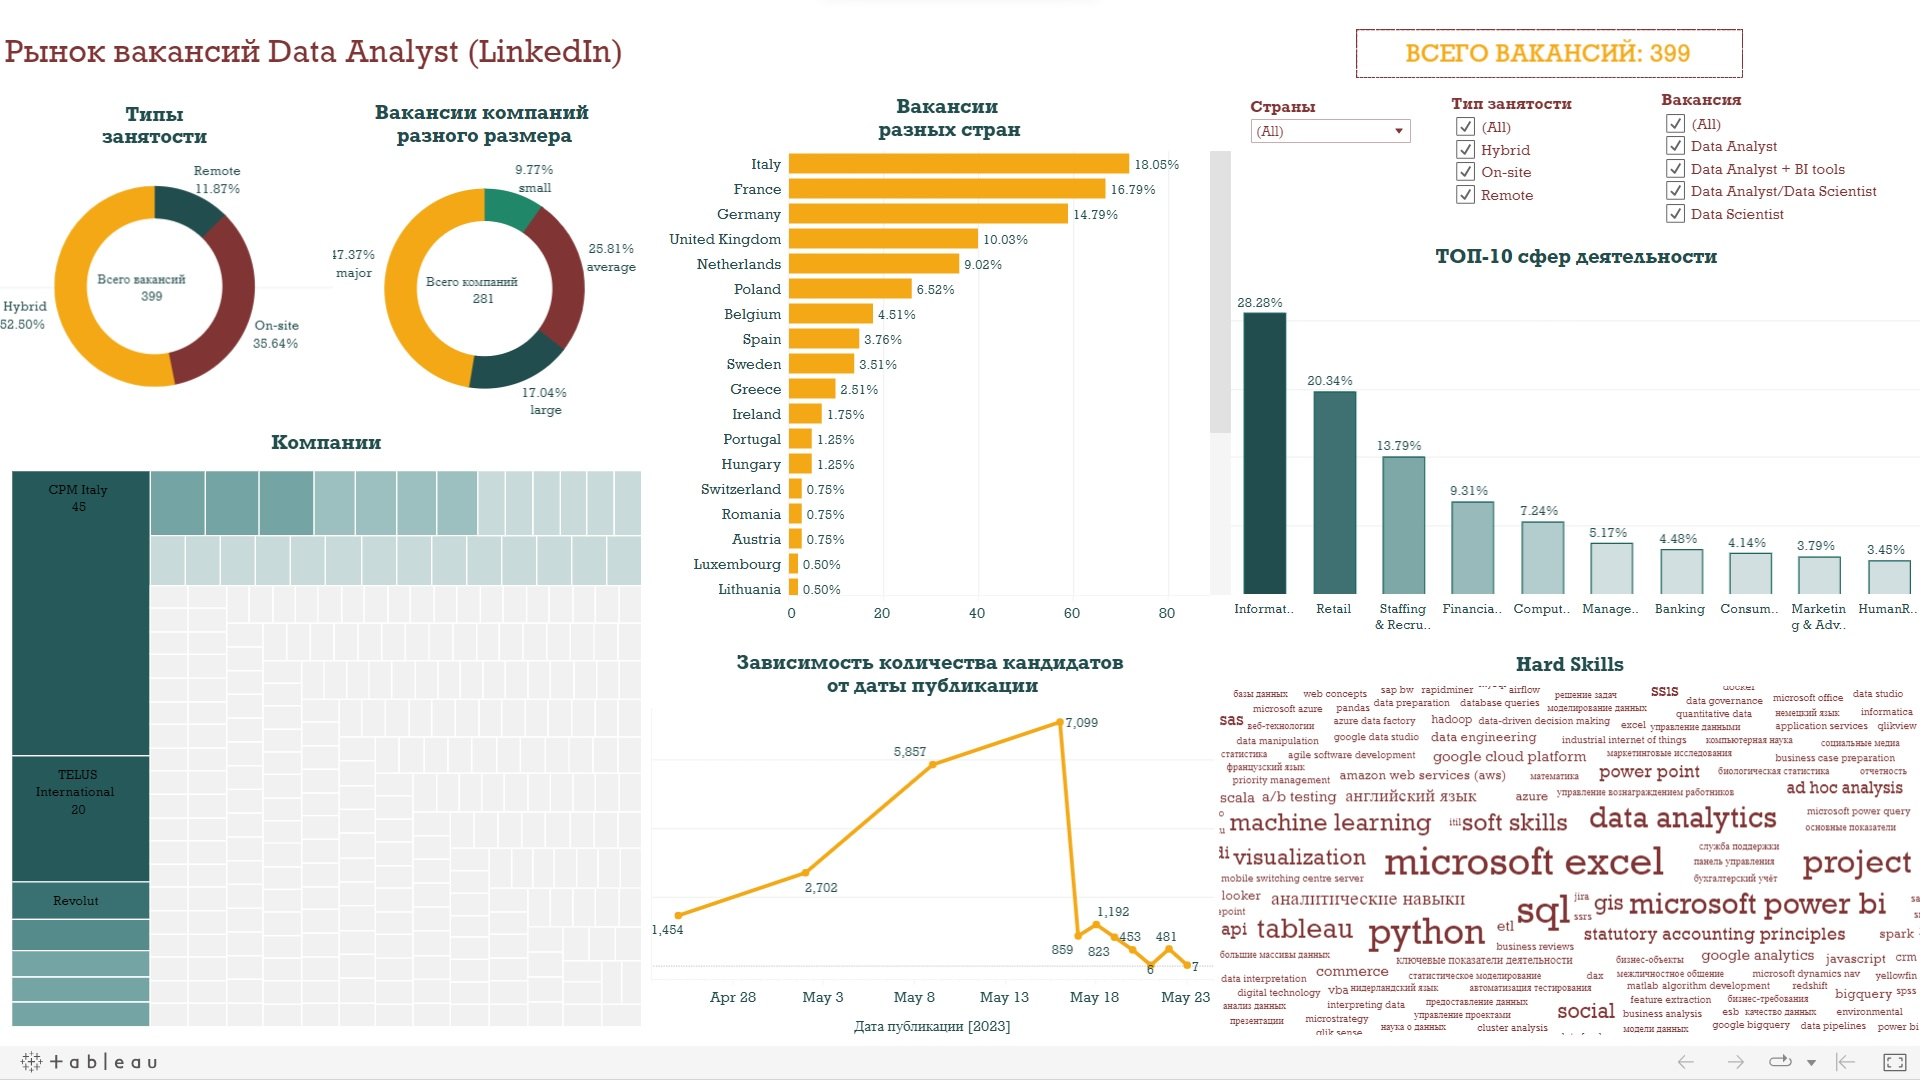